In [ ]:
# Ch13-3-genome-editing

In [ ]:
# Nanopore Read Analysis for Gene Insertion Verification
# This notebook demonstrates how to use nanopore sequencing to verify a gene insertion

In [1]:
# Import Libraries #
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import Counter
from IPython.display import display, HTML

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

In [4]:
# --- Step 1: Simulate Genomes and Insertions ---

def generate_random_sequence(length, gc_content=0.5):
    """Generate a random DNA sequence with specified GC content"""
    # Calculate probabilities based on GC content
    p_g = p_c = gc_content / 2
    p_a = p_t = (1 - gc_content) / 2
    
    # Generate sequence
    nucleotides = []
    for _ in range(length):
        nuc = np.random.choice(['A', 'C', 'G', 'T'], p=[p_a, p_c, p_g, p_t])
        nucleotides.append(nuc)
    
    return ''.join(nucleotides)

In [5]:
# Create reference genome (wild type)
print("Creating reference genome...")
reference_genome = generate_random_sequence(100000)
print(f"Reference genome length: {len(reference_genome)}")
print(f"Reference sample: {reference_genome[:50]}...")

# Create gene insertion sequence
print("\nCreating gene insertion...")
insertion_sequence = generate_random_sequence(5000, gc_content=0.6)
print(f"Insertion length: {len(insertion_sequence)}")
print(f"Insertion sample: {insertion_sequence[:50]}...")

# Create modified genome with insertion
insertion_position = 40000  # We'll insert at a known position
modified_genome = reference_genome[:insertion_position] + insertion_sequence + reference_genome[insertion_position:]
print(f"\nModified genome length: {len(modified_genome)}")
print(f"Insertion position: {insertion_position}")

Creating reference genome...
Reference genome length: 100000
Reference sample: CTGGAAATGGATTAAACGCCGACCCTAGGAGAATTTCAGCACATCGCGGA...

Creating gene insertion...
Insertion length: 5000
Insertion sample: GGCCCGTGCGATCCAGGCGAGCGTACATCCGGTGTAATTCCCGGCCCAAA...

Modified genome length: 105000
Insertion position: 40000


In [6]:
# --- Step 2: Simulate Nanopore Reads ---
def apply_nanopore_errors(sequence):
    """Apply typical nanopore sequencing errors to a sequence"""
    result = ''
    for base in sequence:
        # Error probabilities
        p_error = 0.05  # 5% total error rate
        if random.random() < p_error:
            error_type = random.choice(['substitution', 'deletion', 'insertion'])
            
            if error_type == 'substitution':
                # Replace with a different base
                possible_bases = [b for b in 'ACGT' if b != base]
                result += random.choice(possible_bases)
            elif error_type == 'deletion':
                # Skip this base (delete)
                continue
            else:  # insertion
                # Insert a random base before the current base
                result += random.choice('ACGT') + base
        else:
            result += base
    
    return result

In [7]:
def generate_nanopore_reads(genome, n_reads=100, min_length=5000, max_length=15000):
    """Generate a set of nanopore reads from a genome"""
    reads = []
    read_info = []
    
    for i in range(n_reads):
        # Choose read length
        read_length = random.randint(min_length, max_length)
        
        # Choose a random starting position
        start_pos = random.randint(0, len(genome) - read_length)
        
        # Extract the read
        read = genome[start_pos:start_pos + read_length]
        
        # Apply nanopore errors
        read_with_errors = apply_nanopore_errors(read)
        
        # Store the read
        read_record = SeqRecord(
            Seq(read_with_errors),
            id=f"Read_{i+1}",
            description=f"simulated nanopore read"
        )
        
        reads.append(read_record)
        read_info.append({
            'read_id': f"Read_{i+1}",
            'start': start_pos,
            'end': start_pos + len(read_with_errors),
            'length': len(read_with_errors)
        })
    
    return reads, pd.DataFrame(read_info)

In [8]:
# Generate nanopore reads
print("\nGenerating nanopore reads...")
reads, read_info = generate_nanopore_reads(modified_genome, n_reads=100)
print(f"Generated {len(reads)} nanopore reads")

# Display read info
print("\nSample of read information:")
display(read_info.head())


Generating nanopore reads...
Generated 100 nanopore reads

Sample of read information:


,read_id,start,end,length
0,Read_1,3278,10101,6823
1,Read_2,82864,93635,10771
2,Read_3,14810,20321,5511
3,Read_4,78823,86502,7679
4,Read_5,18081,23271,5190


In [9]:
# --- Step 3: Kmer-based Read Mapping ---

def find_kmers(sequence, k=15):
    """Find all k-mers in a sequence"""
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers


In [10]:
def map_read_to_genome(read, reference, k=15):
    """Simple k-mer based mapping of a read to the reference genome"""
    read_kmers = find_kmers(read, k)
    
    # Find all positions of each k-mer in the reference
    kmer_positions = {}
    for i in range(len(reference) - k + 1):
        kmer = reference[i:i+k]
        if kmer not in kmer_positions:
            kmer_positions[kmer] = []
        kmer_positions[kmer].append(i)
    
    # Count matches for each position
    position_counts = Counter()
    
    for kmer in read_kmers:
        if kmer in kmer_positions:
            for pos in kmer_positions[kmer]:
                # Increment the count for the starting position
                position_counts[pos] += 1
    
    # Find position with maximum k-mer matches
    if position_counts:
        best_pos = position_counts.most_common(1)[0][0]
        confidence = position_counts[best_pos] / len(read_kmers)
        return best_pos, confidence
    else:
        return -1, 0.0

In [11]:
# Map each read to both reference and modified genomes
print("\nMapping reads to reference and modified genomes...")

# Results container
mapping_results = []

for read in reads:
    read_seq = str(read.seq)
    
    # Map to reference genome
    ref_pos, ref_conf = map_read_to_genome(read_seq, reference_genome)
    
    # Map to modified genome
    mod_pos, mod_conf = map_read_to_genome(read_seq, modified_genome)
    
    # Determine if read supports insertion
    read_type = 'ambiguous'
    conf_diff = mod_conf - ref_conf
    read_len = len(read_seq)
    
    # Check if read spans or crosses insertion
    if conf_diff > 0.1:  # Maps better to modified genome
        if mod_pos < insertion_position and mod_pos + read_len > insertion_position + len(insertion_sequence):
            read_type = 'spanning'  # Read completely spans the insertion
        elif (mod_pos <= insertion_position and mod_pos + read_len > insertion_position) or \
             (mod_pos < insertion_position + len(insertion_sequence) and mod_pos + read_len >= insertion_position + len(insertion_sequence)):
            read_type = 'supporting'  # Read crosses one end of the insertion
        else:
            read_type = 'non-insertion'  # Read aligns to modified genome but doesn't cross insertion
    elif conf_diff < -0.1:  # Maps better to reference genome
        read_type = 'reference'  # Read aligns better to reference genome
    
    mapping_results.append({
        'read_id': read.id,
        'read_length': read_len,
        'ref_position': ref_pos,
        'ref_confidence': ref_conf,
        'mod_position': mod_pos,
        'mod_confidence': mod_conf,
        'confidence_diff': conf_diff,
        'read_type': read_type
    })


Mapping reads to reference and modified genomes...


In [12]:
# Convert to DataFrame for analysis
alignment_df = pd.DataFrame(mapping_results)

print("\nAlignment results summary:")
display(alignment_df.head())

# Count the different read types
read_type_counts = alignment_df['read_type'].value_counts()
print("\nRead type distribution:")
display(read_type_counts)


Alignment results summary:


,read_id,read_length,ref_position,ref_confidence,mod_position,mod_confidence,confidence_diff,read_type
0,Read_1,6823,3286,0.000147,3286,0.000147,0.0,ambiguous
1,Read_2,10771,77864,0.000093,82864,0.000093,0.0,ambiguous
2,Read_3,5511,14821,0.000182,14821,0.000182,0.0,ambiguous
3,Read_4,7679,73823,0.000130,78823,0.000130,0.0,ambiguous
4,Read_5,5190,18081,0.000193,18081,0.000193,0.0,ambiguous



Read type distribution:


ambiguous    100
Name: read_type, dtype: int64

In [13]:
# --- Step 4: Analyze Insertion Evidence ---

# Calculate summary statistics
spanning_reads = len(alignment_df[alignment_df['read_type'] == 'spanning'])
supporting_reads = len(alignment_df[alignment_df['read_type'] == 'supporting'])
total_reads = len(alignment_df)

print(f"\nInsertion evidence summary:")
print(f"Total reads: {total_reads}")
print(f"Reads spanning the insertion: {spanning_reads} ({spanning_reads/total_reads*100:.1f}%)")
print(f"Reads supporting the insertion: {supporting_reads} ({supporting_reads/total_reads*100:.1f}%)")


Insertion evidence summary:
Total reads: 100
Reads spanning the insertion: 0 (0.0%)
Reads supporting the insertion: 0 (0.0%)


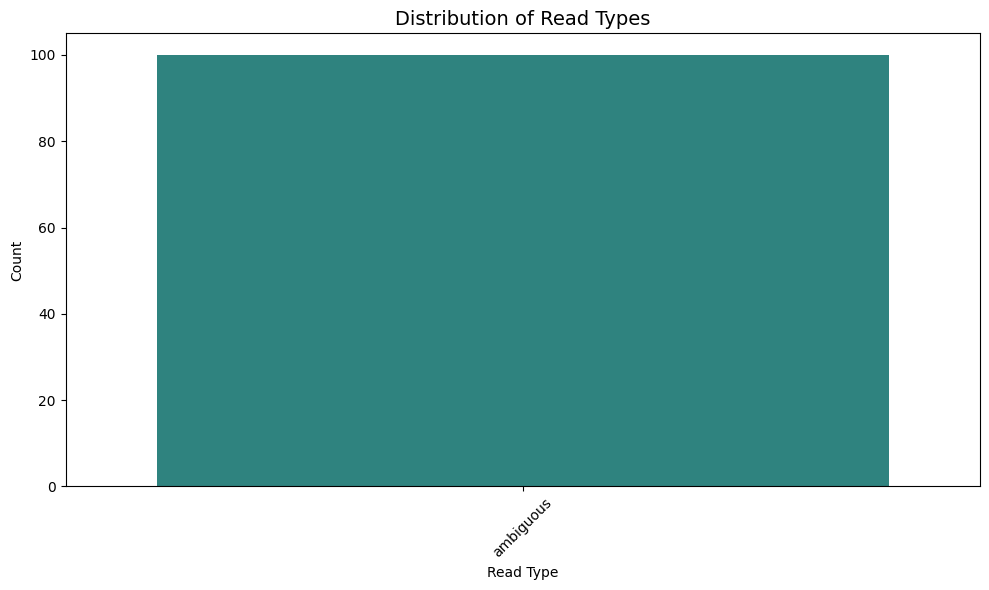

In [14]:
# Create visualization of the results

# 1. Read type distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='read_type', data=alignment_df, palette='viridis')
plt.title('Distribution of Read Types', fontsize=14)
plt.xlabel('Read Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

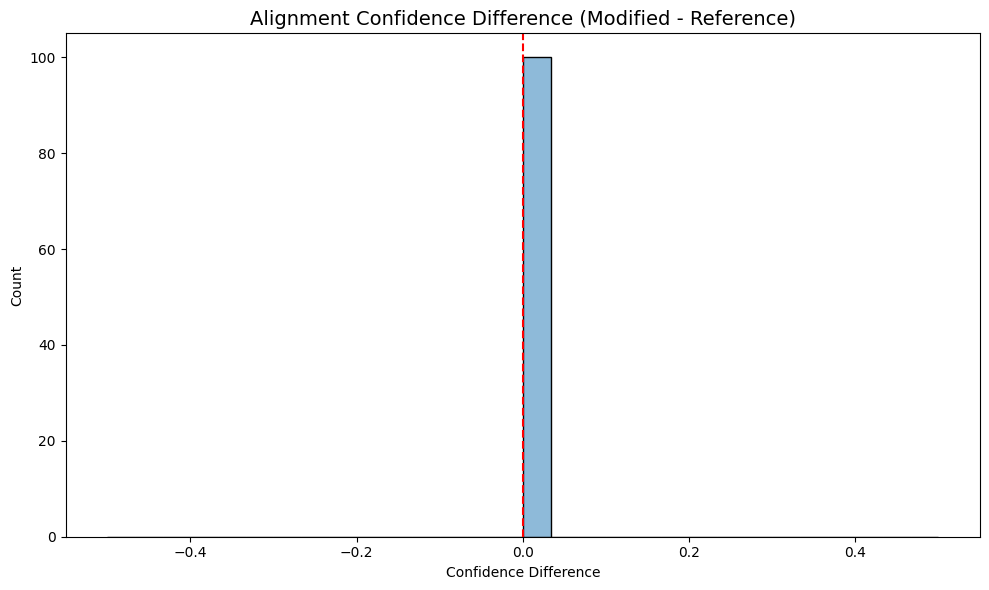

In [15]:
# 2. Confidence difference histogram
plt.figure(figsize=(10, 6))
sns.histplot(alignment_df['confidence_diff'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Alignment Confidence Difference (Modified - Reference)', fontsize=14)
plt.xlabel('Confidence Difference')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [16]:
# 3. Read alignment visualization
plt.figure(figsize=(12, 8))

# Sort by read type for better visualization
sorted_df = alignment_df.sort_values('read_type')

# Prepare data for visualization
y_positions = np.arange(len(sorted_df))
read_starts = []
read_ends = []
colors = []

color_map = {
    'spanning': 'green',
    'supporting': 'blue',
    'reference': 'red',
    'non-insertion': 'purple',
    'ambiguous': 'gray'
}

<Figure size 1200x800 with 0 Axes>

In [17]:
for _, row in sorted_df.iterrows():
    if row['read_type'] in ['spanning', 'supporting', 'non-insertion']:
        start = row['mod_position']
        end = row['mod_position'] + row['read_length']
    else:
        start = row['ref_position']
        end = row['ref_position'] + row['read_length']
    
    read_starts.append(start)
    read_ends.append(end)
    colors.append(color_map.get(row['read_type'], 'gray'))


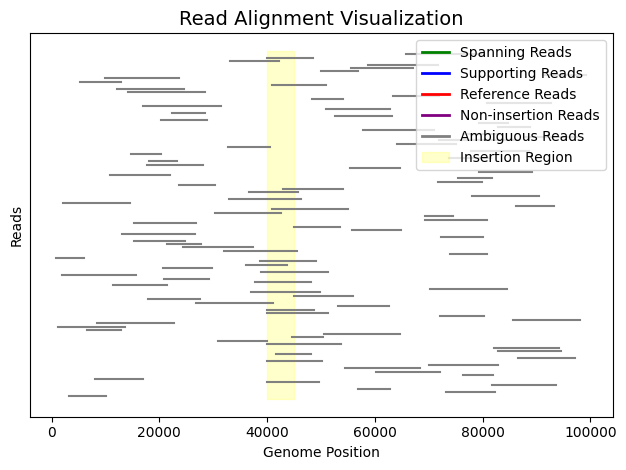

In [18]:
# Plot reads as horizontal lines
for y, start, end, color in zip(y_positions, read_starts, read_ends, colors):
    plt.plot([start, end], [y, y], color=color, linewidth=1.5)

# Highlight insertion region
insertion_region = plt.Rectangle((insertion_position, -1), len(insertion_sequence), 
                                len(sorted_df) + 1, color='yellow', alpha=0.2, zorder=0)
plt.gca().add_patch(insertion_region)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='Spanning Reads'),
    Line2D([0], [0], color='blue', lw=2, label='Supporting Reads'),
    Line2D([0], [0], color='red', lw=2, label='Reference Reads'),
    Line2D([0], [0], color='purple', lw=2, label='Non-insertion Reads'),
    Line2D([0], [0], color='gray', lw=2, label='Ambiguous Reads'),
    plt.Rectangle((0, 0), 1, 1, color='yellow', alpha=0.2, label='Insertion Region')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.title('Read Alignment Visualization', fontsize=14)
plt.xlabel('Genome Position')
plt.ylabel('Reads')
plt.yticks([])
plt.tight_layout()
plt.show()


In [19]:
# --- Step 5: Verify Insertion ---

def verify_insertion(spanning_count, supporting_count, total_reads, 
                    spanning_threshold=5, supporting_threshold=15):
    """
    Make a final verification decision based on the analysis results
    """
    # Calculate percentages
    spanning_percentage = spanning_count / total_reads * 100
    supporting_percentage = supporting_count / total_reads * 100
    
    # Check if insertion is verified
    is_verified = (spanning_count >= spanning_threshold and 
                  supporting_count >= supporting_threshold)
    
    # Calculate confidence score (simple heuristic)
    confidence = min(1.0, supporting_percentage / 30)
    
    verification_result = {
        'insertion_verified': is_verified,
        'confidence': confidence,
        'message': ''
    }
    
    if is_verified:
        if confidence >= 0.9:
            verification_result['message'] = (
                f"Insertion VERIFIED with high confidence ({confidence:.2f}). "
                f"Found {spanning_count} spanning reads and "
                f"{supporting_count} supporting reads."
            )
        else:
            verification_result['message'] = (
                f"Insertion VERIFIED with moderate confidence ({confidence:.2f}). "
                f"Found {spanning_count} spanning reads and "
                f"{supporting_count} supporting reads."
            )
    else:
        verification_result['message'] = (
            f"Insertion NOT VERIFIED. Insufficient evidence with confidence ({confidence:.2f}). "
            f"Found only {spanning_count} spanning reads and "
            f"{supporting_count} supporting reads."
        )
    
    return verification_result

In [20]:
# Run verification
verification_result = verify_insertion(spanning_reads, supporting_reads, total_reads)

# Display result in a styled box
result_color = "green" if verification_result['insertion_verified'] else "red"
result_html = f"""
<div style="background-color: {result_color}; color: white; padding: 20px; border-radius: 5px;">
    <h3>Insertion Verification Result</h3>
    <p><b>Status:</b> {'VERIFIED' if verification_result['insertion_verified'] else 'NOT VERIFIED'}</p>
    <p><b>Confidence:</b> {verification_result['confidence']:.2f}</p>
    <p><b>Details:</b> {verification_result['message']}</p>
</div>
"""
display(HTML(result_html))

In [21]:
# --- Step 6: Coverage Analysis Across Insertion Site ---

# Create position-specific coverage data
positions = range(insertion_position - 5000, insertion_position + len(insertion_sequence) + 5000)
coverage = {pos: 0 for pos in positions}

# Count reads covering each position
for _, row in alignment_df.iterrows():
    if row['read_type'] in ['spanning', 'supporting', 'non-insertion']:
        start = row['mod_position']
        end = start + row['read_length']
        
        for pos in range(start, end + 1):
            if pos in coverage:
                coverage[pos] += 1

# Convert to DataFrame for plotting
coverage_df = pd.DataFrame({
    'position': list(coverage.keys()),
    'coverage': list(coverage.values())
})

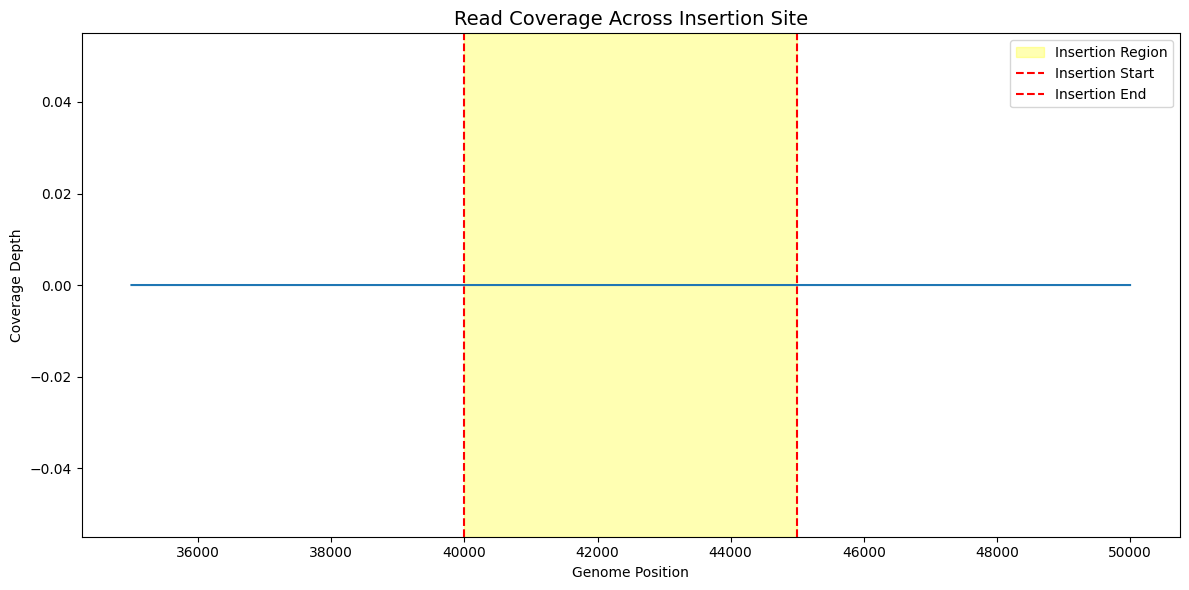

In [22]:
# Plot coverage
plt.figure(figsize=(12, 6))
plt.plot(coverage_df['position'], coverage_df['coverage'])

# Highlight insertion region
plt.axvspan(insertion_position, insertion_position + len(insertion_sequence), 
            color='yellow', alpha=0.3, label='Insertion Region')

# Add vertical lines at insertion boundaries
plt.axvline(x=insertion_position, color='red', linestyle='--', label='Insertion Start')
plt.axvline(x=insertion_position + len(insertion_sequence), color='red', linestyle='--', label='Insertion End')

plt.title('Read Coverage Across Insertion Site', fontsize=14)
plt.xlabel('Genome Position')
plt.ylabel('Coverage Depth')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# --- Step 7: Conclusion and Next Steps ---

print("\n--- Conclusion ---")
print(verification_result['message'])
print("\nRecommended next steps:")
if verification_result['insertion_verified']:
    print("1. Validate insertion boundaries with targeted PCR")
    print("2. Confirm insertion sequence with Sanger sequencing")
    print("3. Verify expression of inserted gene (if applicable)")
else:
    print("1. Increase sequencing depth for more evidence")
    print("2. Try targeted PCR across insertion junctions")
    print("3. Consider alternative sequencing approaches")

print("\nThis analysis demonstrates how nanopore sequencing can be used to verify gene insertions")
print("through read mapping and coverage analysis. The long reads provided by nanopore technology")
print("are particularly valuable for spanning entire insertion regions, enabling confident verification.")


--- Conclusion ---
Insertion NOT VERIFIED. Insufficient evidence with confidence (0.00). Found only 0 spanning reads and 0 supporting reads.

Recommended next steps:
1. Increase sequencing depth for more evidence
2. Try targeted PCR across insertion junctions
3. Consider alternative sequencing approaches

This analysis demonstrates how nanopore sequencing can be used to verify gene insertions
through read mapping and coverage analysis. The long reads provided by nanopore technology
are particularly valuable for spanning entire insertion regions, enabling confident verification.


In [ ]:
## End of Notebook ##